In [ ]:
import cv2
import numpy as np
import math
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
from scipy.spatial import distance

**Реализация с помощью готовых функций open-cv**

Сшивание успешно выполнено.


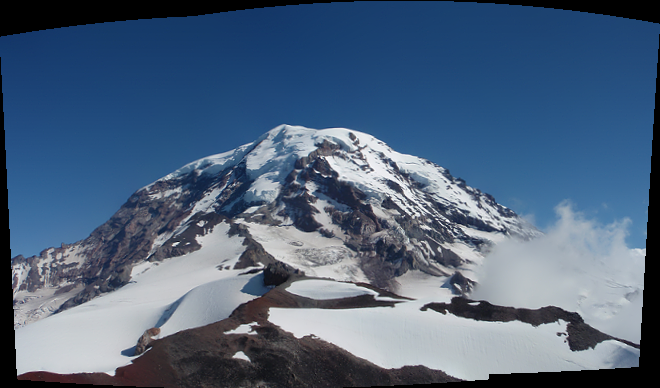

In [ ]:
def stitch_images(img1_path, img2_path):
  img1 = cv2.imread(img1_path)
  img2 = cv2.imread(img2_path)

  stitcher = cv2.Stitcher_create()

  status, stitched = stitcher.stitch([img1, img2])

  if status == cv2.Stitcher_OK:
      print("Сшивание успешно выполнено.")
      return stitched
  else:
      print("Ошибка сшивания: ", status)
      return None

img1_path = '/content/drive/MyDrive/CV_lab3-main/data/Rainier1.png'
img2_path = '/content/drive/MyDrive/CV_lab3-main/data/Rainier2.png'

stitched_image = stitch_images(img1_path, img2_path)

if stitched_image is not None:
    cv2_imshow(stitched_image)

In [ ]:
def harris_corners(image):
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  gray = np.float32(gray)
  sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
  sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)

  Ixx = sobel_x * sobel_x
  Ixy = sobel_x * sobel_y
  Iyy = sobel_y * sobel_y

  k = 0.04
  block_size = 2

  height, width = gray.shape
  R = np.zeros((height, width))

  for i in range(block_size, height - block_size):
      for j in range(block_size, width - block_size):
          Sxx = np.sum(Ixx[i-block_size:i+block_size+1, j-block_size:j+block_size+1])
          Sxy = np.sum(Ixy[i-block_size:i+block_size+1, j-block_size:j+block_size+1])
          Syy = np.sum(Iyy[i-block_size:i+block_size+1, j-block_size:j+block_size+1])

          M = np.array([[Sxx, Sxy],
                        [Sxy, Syy]])

          det_M = np.linalg.det(M)
          trace_M = np.trace(M)

          R[i, j] = det_M - k * (trace_M ** 2)

  R = cv2.dilate(R, None)
  threshold = 0.01 * np.max(R)
  keypoints = np.argwhere(R > threshold)

  return keypoints

def compute_descriptors(image, keypoints):
  sift = cv2.SIFT_create()  # Вычисляем дескрипторы для ключевых точек, используя SIFT

  keypoints_cv2 = [cv2.KeyPoint(float(kp[1]), float(kp[0]), 1) for kp in keypoints]  # Преобразуем углы в формат OpenCV KeyPoint

  #дескрипторы
  keypoints_cv2, descriptors = sift.compute(image, keypoints_cv2)
  return keypoints_cv2, descriptors

def match_descriptors(descriptors1, descriptors2):
  # Использую BFMatcher для того чтобы сопоставить дескрипторов
  bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)
  matches = bf.knnMatch(descriptors1, descriptors2, k=2)

  good_matches = []
  for m, n in matches:
      if m.distance < 0.75 * n.distance:
          good_matches.append(m)

  return good_matches

def find_homography(keypoints1, keypoints2, matches):
  if len(matches) < 4:
      raise ValueError("Недостаточно совпадений для вычисления гомографии.")

  points1 = np.float32([keypoints1[m.queryIdx].pt for m in matches])
  points2 = np.float32([keypoints2[m.trainIdx].pt for m in matches])

  #Гомография с использованием готового RANSAC
  H, mask = cv2.findHomography(points1, points2, cv2.RANSAC)
  return H

def stitch_images(img1_path, img2_path):
  img1 = cv2.imread(img1_path)
  img2 = cv2.imread(img2_path)

  keypoints1 = harris_corners(img1)
  keypoints2 = harris_corners(img2)

  #Вычисление дескрипторов
  keypoints1_cv2, descriptors1 = compute_descriptors(img1, keypoints1)
  keypoints2_cv2, descriptors2 = compute_descriptors(img2, keypoints2)

  #Сопоставление дескрипторов
  good_matches = match_descriptors(descriptors1, descriptors2)

  #Вычисление гомографии
  H = find_homography(keypoints1_cv2, keypoints2_cv2, good_matches)

  #Сшивка изображений
  height1, width1 = img1.shape[:2]
  height2, width2 = img2.shape[:2]

  #размеры для итогового изображения
  points1 = np.float32([[0, 0], [0, height1], [width1, height1], [width1, 0]]).reshape(-1, 1, 2)
  points2 = np.float32([[0, 0], [0, height2], [width2, height2], [width2, 0]]).reshape(-1, 1, 2)

  #Ну и применение гомографии к углам второго изображения
  points2_transformed = cv2.perspectiveTransform(points2, H)

  #Объединяем точки для нахождения границ итогового изображения
  all_points = np.concatenate((points1, points2_transformed), axis=0)
  [x_min, y_min] = np.int32(all_points.min(axis=0).ravel()) - 10
  [x_max, y_max] = np.int32(all_points.max(axis=0).ravel()) + 10

  # Создаем итоговое изображение с учетом границ
  translation_dist = [-x_min, -y_min]
  H_translation = np.array([[1, 0, translation_dist[0]],
                            [0, 1, translation_dist[1]],
                            [0, 0, 1]])

  stitched_image = cv2.warpPerspective(img1, H_translation @ H, (x_max - x_min, y_max - y_min))

  stitched_image[translation_dist[1]:height2 + translation_dist[1], translation_dist[0]:width2 + translation_dist[0]] = img2

  return stitched_image

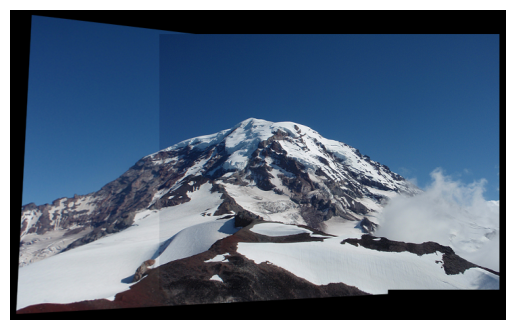

In [ ]:
img1_path = '/content/drive/MyDrive/CV_lab3-main/data/Rainier1.png'
img2_path = '/content/drive/MyDrive/CV_lab3-main/data/Rainier2.png'

stitched_image = stitch_images(img1_path, img2_path)

if stitched_image is not None:
  plt.imshow(cv2.cvtColor(stitched_image, cv2.COLOR_BGR2RGB))
  plt.axis('off')
  plt.show()


**Реализация в ручную**

**Детектор углов Харриса**

In [ ]:
def harris_corners(image, k=0.04, threshold=0.1):
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY).astype(np.float32)
  sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
  sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)

  Ixx = sobel_x ** 2
  Iyy = sobel_y ** 2
  Ixy = sobel_x * sobel_y

  Ixx = cv2.GaussianBlur(Ixx, (5, 5), 1)
  Iyy = cv2.GaussianBlur(Iyy, (5, 5), 1)
  Ixy = cv2.GaussianBlur(Ixy, (5, 5), 1)

  height, width = gray.shape
  corners = np.zeros((height, width))

  for i in range(height):
      for j in range(width):
          M = np.array([[Ixx[i,j], Ixy[i,j]],
                        [Ixy[i,j], Iyy[i,j]]])
          det_M = np.linalg.det(M)
          trace_M = np.trace(M)
          corners[i,j] = det_M - k * (trace_M ** 2)

  corners = corners / corners.max()
  corners[corners < threshold] = 0
  return corners

**Извлечение ключевых точек и дескрипторов изображения**

In [ ]:
def extract_keypoints_and_descriptors(image, corners, window_size=20):
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY).astype(np.float32)
  keypoints = []
  descriptors = []
  offset = window_size // 2
  height, width = gray.shape

  corner_coords = np.argwhere(corners > 0) # получаем координаты углов
  for y, x in corner_coords:
      if offset <= x < width - offset and offset <= y < height - offset:
        keypoints.append((x, y))
        window = gray[y - offset : y + offset, x - offset : x + offset].flatten()
        descriptors.append(window)
  return np.array(keypoints), np.array(descriptors)

**Сопоставление дескрипторов, и получение соответствий вместе с точками**

In [ ]:
def match_descriptors(descriptors1, descriptors2, keypoints1, keypoints2):
  matches = []
  if len(descriptors1) == 0 or len(descriptors2) == 0:
      return matches
  dists = distance.cdist(descriptors1, descriptors2, 'euclidean')
  for i, dist_row in enumerate(dists):
    match_idx = np.argmin(dist_row)
    matches.append((keypoints1[i], keypoints2[match_idx]))
  return matches

**Здесь происходит вычисление гомографической матрицы с использованием 5 точек(Для 3 че-то плохо получилось)**

In [ ]:
def compute_homography(points1, points2):
  if len(points1) != 5 or len(points2) != 5:
      raise ValueError("Для вычисления гомографии требуется 5 точек")

  A = []
  for p1, p2 in zip(points1, points2):
      x1, y1 = p1
      x2, y2 = p2
      A.append([x1, y1, 1, 0, 0, 0, -x2 * x1, -x2 * y1, -x2])
      A.append([0, 0, 0, x1, y1, 1, -y2 * x1, -y2 * y1, -y2])
  A = np.array(A)
  try:
      U, S, V = np.linalg.svd(A)
  except np.linalg.LinAlgError:
      return None
  H = V[-1].reshape(3, 3)
  H /= H[2, 2]
  return H

**Оценка гомографической матрицы с помощью RANSAC, используя 5 точек**

In [ ]:
def ransac(matches, iterations=1000, threshold=10.0):

  best_H = None
  max_inliers = 0
  for _ in range(iterations):
      # Выбираем случайную группу из 5 соответствий
      random_matches_idx = np.random.choice(len(matches), 5, replace=False)
      random_matches = [matches[idx] for idx in random_matches_idx]

      # Находим точки в обоих изображениях
      points1 = []
      points2 = []
      for match in random_matches:
            points1.append(match[0])
            points2.append(match[1])


      points1 = np.array(points1)
      points2 = np.array(points2)

      # Вычисляем гомографию
      H = compute_homography(points1, points2)
      if H is None:
          continue

      # Считаем количество соответствий, которые соответствуют нашей гомографии
      inliers = 0
      for match in matches:
          point1, point2 = match
          point1_homo = np.array([point1[0], point1[1], 1]).T
          transformed_point1 = H @ point1_homo
          transformed_point1 /= transformed_point1[2]

          dist = math.sqrt( (point2[0] - transformed_point1[0])**2 + (point2[1] - transformed_point1[1])**2)
          if dist < threshold:
              inliers += 1

      if inliers > max_inliers:
          max_inliers = inliers
          best_H = H

  return best_H

**Ну и собственно находим гомографию с помощью RANSAC**

In [ ]:
def find_homography(keypoints1, keypoints2, matches):
  if len(matches) < 5:
      raise ValueError("Недостаточно совпадений для вычисления гомографии.")
  H = ransac(matches)
  return H

**Склеиваем изображения**

In [ ]:
def stitch_images(img1, img2):
  corners1 = harris_corners(img1)
  keypoints1, descriptors1 = extract_keypoints_and_descriptors(img1, corners1)

  corners2 = harris_corners(img2)
  keypoints2, descriptors2 = extract_keypoints_and_descriptors(img2, corners2)

  matches = match_descriptors(descriptors1, descriptors2, keypoints1, keypoints2)

  H = find_homography(keypoints1, keypoints2, matches)

  if H is None or H.size == 0:
      print("Failed to compute homography.")
      return None

  # Находим размеры итогового изображения
  height1, width1 = img1.shape[:2]
  height2, width2 = img2.shape[:2]

  points_img2_corners = np.array([[0, 0], [width2-1, 0], [width2-1, height2-1], [0, height2-1]])
  points_img2_corners_homogeneous = np.hstack((points_img2_corners, np.ones((4, 1)))).T
  transformed_corners_img2 = H @ points_img2_corners_homogeneous
  transformed_corners_img2 /= transformed_corners_img2[2]
  min_x = int(min(transformed_corners_img2[0]))
  max_x = int(max(transformed_corners_img2[0]))
  min_y = int(min(transformed_corners_img2[1]))
  max_y = int(max(transformed_corners_img2[1]))

  # Создание итогового изображения
  stitched_image_width = max(max_x - min_x + width1, width1)
  stitched_image_height = max(max_y - min_y + height1, height1)
  stitched_image = np.zeros((stitched_image_height, stitched_image_width, 3), dtype=np.uint8)

  # Переносим первое изображение в итоговое
  stitched_image[0:height1, 0:width1] = img1

  # Создаем копию img2 для изменений
  img2_copy = img2.copy()

  # Применяем гомографическое преобразование ко второму изображению и вставляем в итоговое
  for y in range(height2):
      for x in range(width2):
          if img2_copy[y, x].any():
              new_point_homogeneous = H @ np.array([x, y, 1])
              new_point_homogeneous /= new_point_homogeneous[2]
              new_x = int(new_point_homogeneous[0]) - min_x
              new_y = int(new_point_homogeneous[1]) - min_y

              if (0 <= new_x < stitched_image_width) and (0 <= new_y < stitched_image_height):
                  alpha = 1.0  # По умолчанию, если нет области перекрытия

                  # Проверка на перекрытие
                  if (0 <= new_x < width1) and (0 <= new_y < height1) :
                      alpha = 0.5 # Смешиваем в областях перекрытия

                  if img2_copy[y, x].shape == (3,):
                      stitched_image[new_y, new_x] = (alpha * stitched_image[new_y, new_x] + (1-alpha) * img2_copy[y, x]).astype(np.uint8)
                  else:
                      if img2_copy[y, x].shape[0] == 4:
                          img2_copy[y, x] = cv2.cvtColor(img2_copy[y, x].reshape(1, 1, -1), cv2.COLOR_RGBA2BGR).reshape(3)
                      stitched_image[new_y, new_x] = (alpha * stitched_image[new_y, new_x] + (1-alpha) * img2_copy[y, x]).astype(np.uint8)
  return stitched_image

**Вывод того, что получилось**

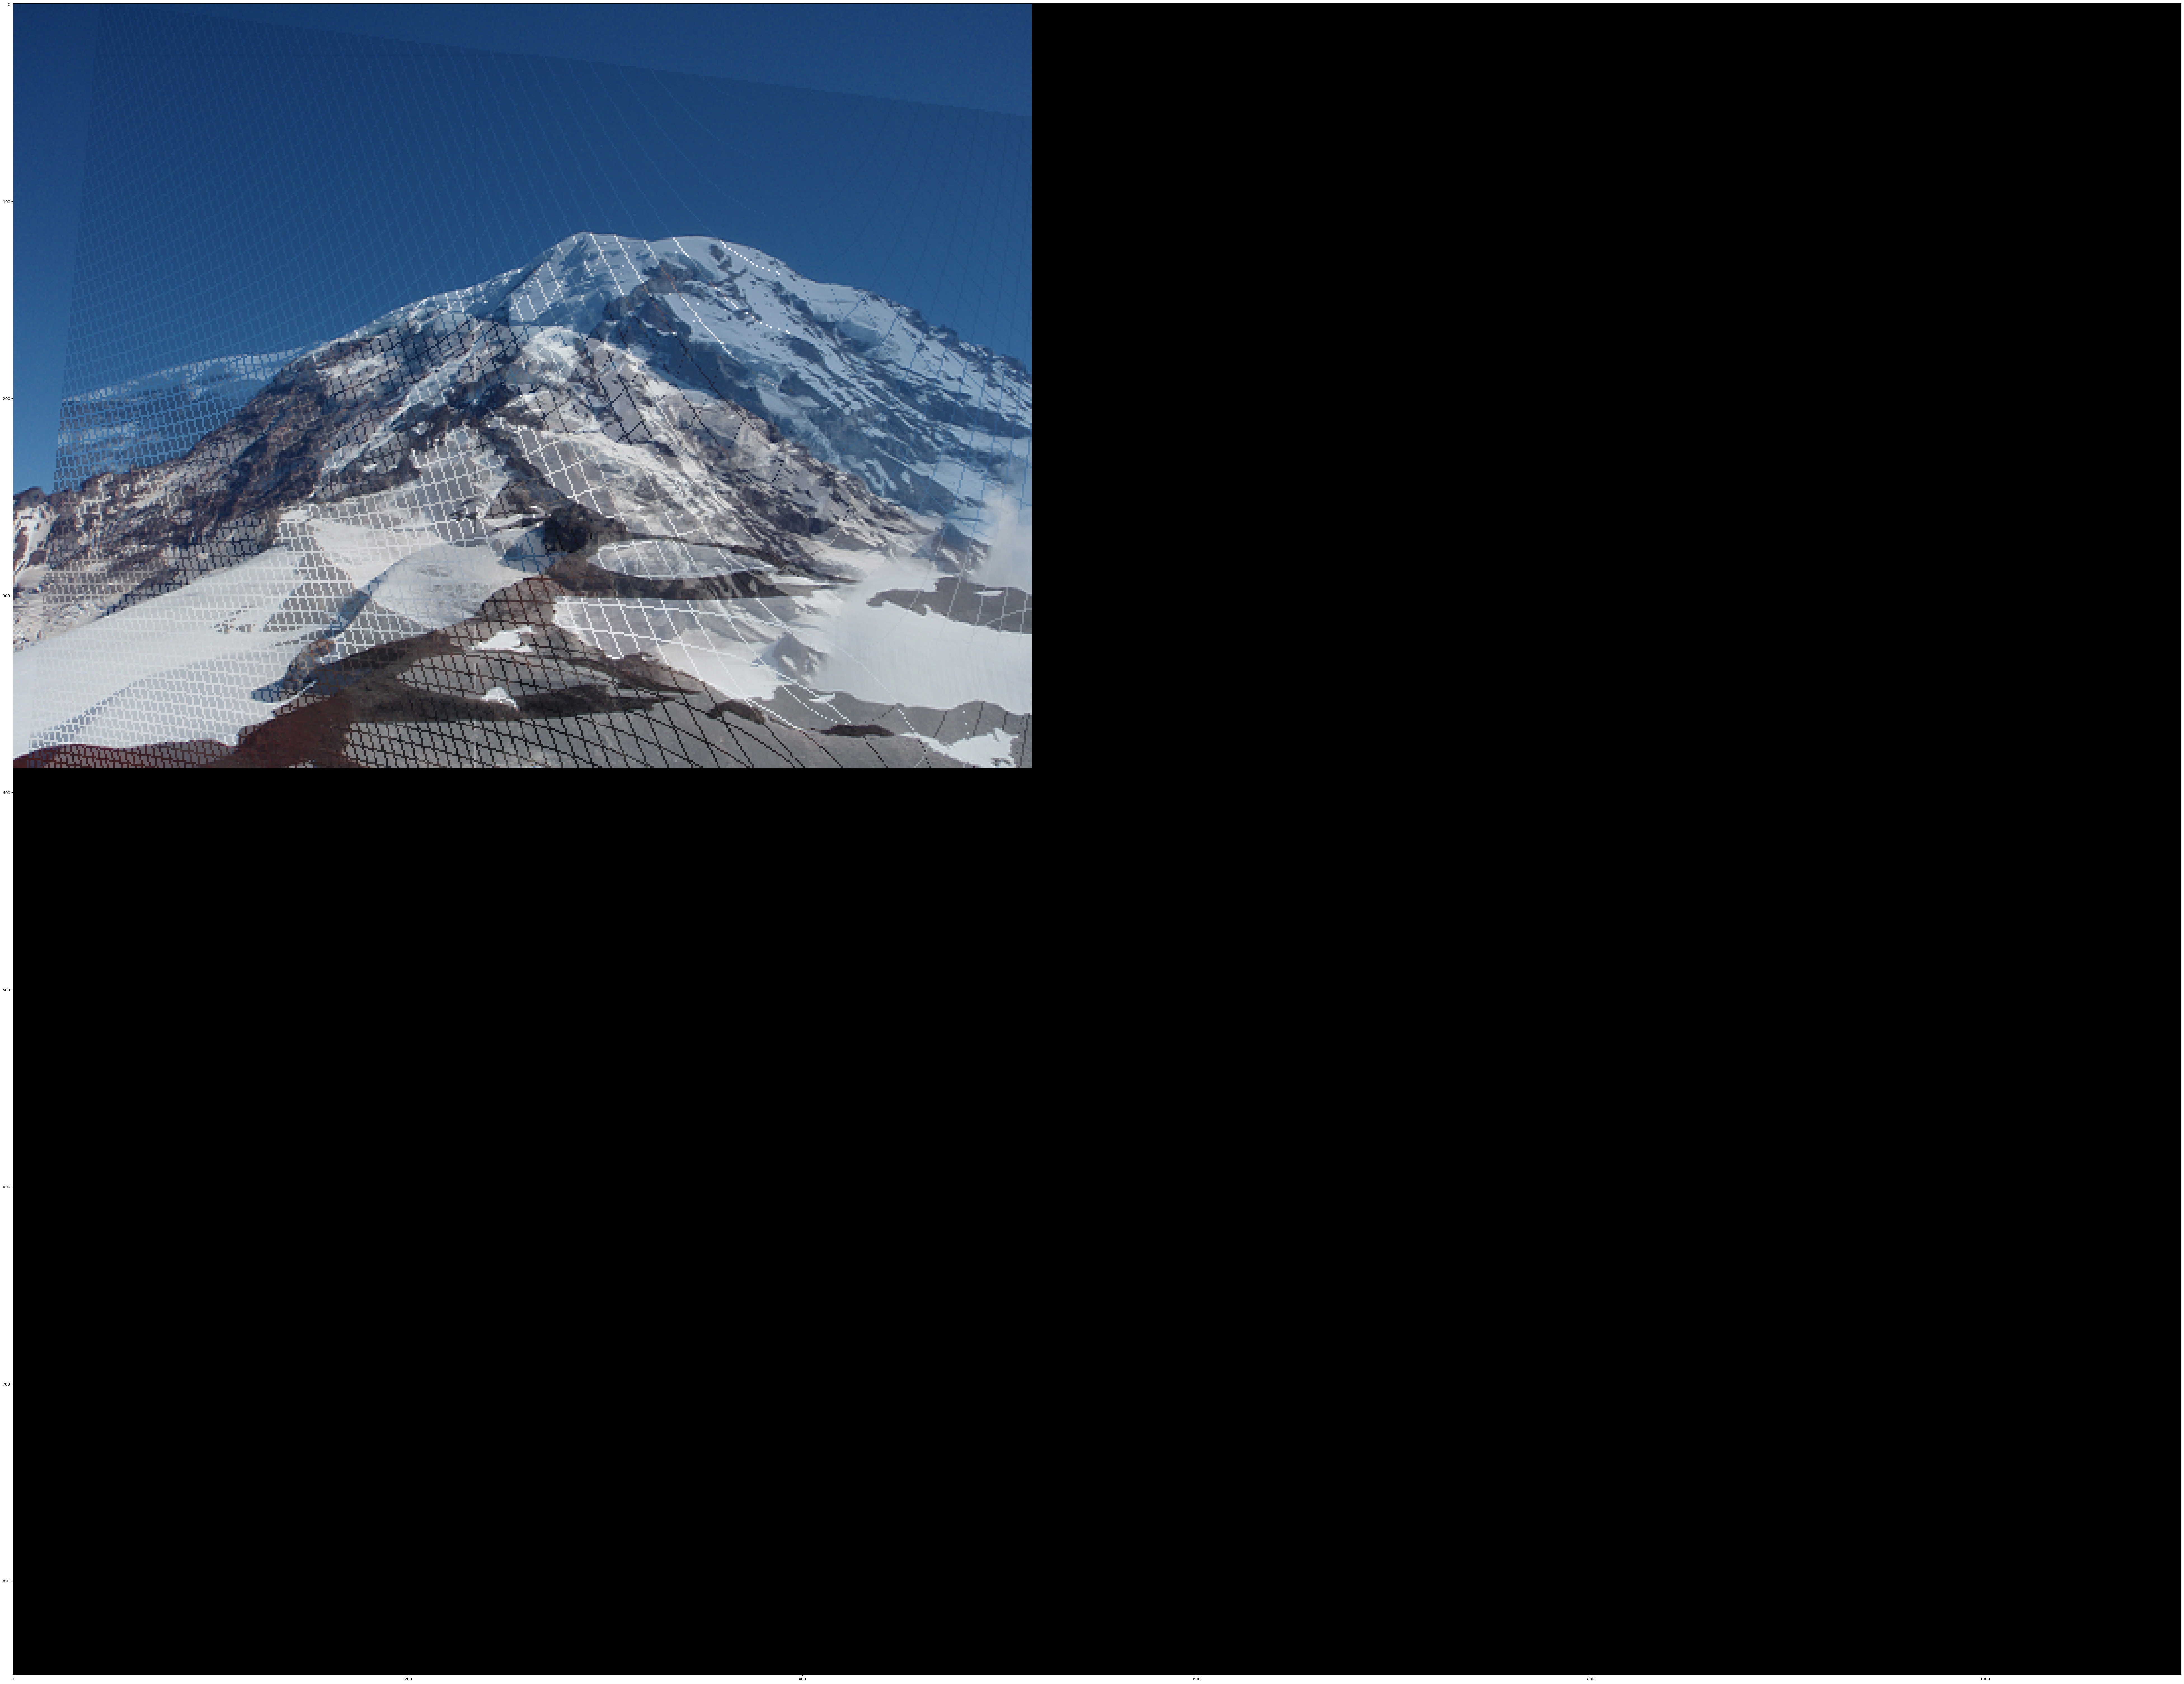

In [ ]:
def stitch_panorama(image_path1, image_path2):
  # функция для сшивки панорамы
  img1 = cv2.imread(image_path1)
  img2 = cv2.imread(image_path2)

  if img1 is None or img2 is None:
      print("Error: Unable to load images.")
      return None

  panorama = stitch_images(img1, img2)
  return panorama


image_path1 = '/content/drive/MyDrive/CV_lab3-main/data/Rainier1.png'  # Замените на путь к вашему первому изображению
image_path2 = '/content/drive/MyDrive/CV_lab3-main/data/Rainier2.png'  # Замените на путь ко второму изображению

panorama = stitch_panorama(image_path1, image_path2)

if panorama is not None:
  plt.figure(figsize=(100, 80))
  plt.imshow(cv2.cvtColor(panorama, cv2.COLOR_BGR2RGB))
  plt.show()
else:
  print("Не удалось создать панораму из-за недостаточного количества совпадений.")